<img align="center" style="max-width: 1000px" src="https://github.com/HSG-AIML-Teaching/GSERM2025-Lab/blob/main/lab_06/banner.png?raw=1">

##  Lab 06 - Autoencoder Neural Networks

GSERM Summer School 2025, Deep Learning: Fundamentals and Applications, University of St. Gallen

The lab environment is based on Jupyter Notebooks (https://jupyter.org), which provide an interactive platform for performing a variety of statistical evaluations and data analyses. In this lab, we will learn how to enhance vanilla **Artificial Neural Networks (ANNs)** using `PyTorch` to detect anomalies in financial accounting records. To achieve this, we will explore a special type of deep neural network known as **Autoencoder Neural Networks (AENNs)**. AENNs leverage the ability to learn efficient data representations, allowing them to identify unusual patterns that may indicate anomalies.

The history of AENNs is rich and exhibits pivotal contributions from researchers like *Geoffrey Hinton* and *Ruslan Salakhutdinov*, who developed foundational techniques for deep learning and representation learning. AENNs have since become a cornerstone in the field of unsupervised learning, significantly advancing the capabilities of anomaly detection and data compression.

In this lab, we will apply AENNs to detect anomalies in financial accounting records. AENNs learn to **encode** input data into a low-dimensional representation and **decode** the original data from this encoded representation. The decoded data, or **reconstruction**, should closely match the original **input data**, so entries that can only be reconstructed with errors likely exhibit unusual characteristics.

The figure below illustrates a high-level view of the deep learning process we aim to establish in this lab.

<img align="center" style="max-width: 900px" src="https://github.com/HSG-AIML-Teaching/GSERM2025-Lab/blob/main/lab_06/process.png?raw=1">

Using the `PyTorch` library, we will implement and train the AENN to learn the features of historical **bookings** or **journal entries**. After training, we will apply the model to detect anomalies based on reconstruction errors and use the learned **representations** to interpret the results meaningfully. The figure below provides an overview of the deep learning process and the AENN network architecture we will implement.

As always, pls. don't hesitate to ask all your questions either during the lab, post them in our CANVAS (StudyNet) forum (https://learning.unisg.ch), or send us an email (using the course email).

Before we start let's watch a motivational video:

In [ ]:
from IPython.display import YouTubeVideo
# Google Deepmind | AlphaStar: The inside story
# YouTubeVideo('UuhECwm31dM', width=800, height=400)

## 1. Lab Objectives:

After today's lab, you should be able to:

> 1. **Understand Autoencoder Neural Network (AENN) Design:** Learn the fundamental concepts and architectural design of AENNs.
> 2. **Implement and Train an AENN Model:** Gain hands-on experience with PyTorch to implement, train, and evaluate AENN models.
> 3. **Apply AENN Models for Anomaly Detection:** Use AENNs to detect anomalies in synthetic financial datasets, specifically in accounting journal entries.
> 4. **Evaluate and Interpret Model Performance:** Evaluate the AENN model's performance using reconstruction error metrics and interpret the results.
> 5. **Visualize and Interpret Learned Representations:** Visualize and interpret the learned representations to gain deeper insights into the data's semantics.


## 2. Setup of the Jupyter Notebook Environment

Similar to the previous labs, we need to import several Python libraries that facilitate data analysis and visualization. We will primarily use `PyTorch`, `NumPy`, `Scikit-learn`, `Matplotlib`, `Seaborn`, and a few utility libraries throughout this lab:

In [1]:
# import python data science and utility libraries
import os, sys, itertools, urllib, io, warnings
import datetime as dt
import pandas as pd
import pandas_datareader as dr
import numpy as np

Import `Python` machine learning and deep learning libraries:

In [2]:
# pytorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torch.utils.data import dataloader

Import `Matplotlib` and `Seaborn` data visualization libraries:

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi']= 150

Turn off possible warnings, e.g., due to future changes in the libraries:

In [4]:
# set the warning filter flag to ignore warnings
warnings.filterwarnings('ignore')

Enable inline plotting with `Matplotlib`:

In [5]:
%matplotlib inline

Import Google's `GDrive` connector and mount your `GDrive` directories:

In [6]:
# import the Google Colab GDrive connector
from google.colab import drive

# mount GDrive inside the Colab notebook
drive.mount('/content/drive')

Mounted at /content/drive


Create a structure of Colab Notebook sub-directories inside of GDrive to store (1) the `GDrive` notebooks in general, (2) saving the original data, (3) the analysis results, and (4) the trained models:

In [7]:
# create Colab Notebooks directory
notebook_directory = '/content/drive/MyDrive/Colab Notebooks'
if not os.path.exists(notebook_directory): os.makedirs(notebook_directory)

 # create data sub-directory inside the Colab Notebooks directory
data_directory = '/content/drive/MyDrive/Colab Notebooks/data_ano'
if not os.path.exists(data_directory): os.makedirs(data_directory)

# create results sub-directory inside the Colab Notebooks directory
results_directory = '/content/drive/MyDrive/Colab Notebooks/results_ano'
if not os.path.exists(results_directory): os.makedirs(results_directory)

 # create models sub-directory inside the Colab Notebooks directory
models_directory = '/content/drive/MyDrive/Colab Notebooks/models_ano'
if not os.path.exists(models_directory): os.makedirs(models_directory)

Set a random `seed` value to obtain reproducible results:

In [8]:
# init deterministic seed
seed_value = 1234
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value); # set pytorch seed cpu

Google Colab provides free GPUs for running notebooks. However, if you execute this notebook as is, it will use your device's CPU. To run the lab on a GPU, go to `Runtime` > `Change runtime type` and set the Runtime type to `GPU` in the drop-down menu. Running this lab on a CPU is fine, but you will find that GPU computing is faster. *CUDA* indicates that the lab is being run on a GPU.

Enable GPU computing by setting the device flag and initializing a CUDA seed:

In [9]:
# set cpu or gpu enabled device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

# set pytorch gpu seed
torch.cuda.manual_seed(seed_value)

# log type of device enabled
now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
print('[LOG {}] notebook with {} computation enabled'.format(str(now), str(device)))

[LOG 2025.06.11-12:38:17] notebook with cpu computation enabled


Let's determine if we have access to a GPU provided by environments such as `Google Colab`:

In [10]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


Let's determine the available `Python` and `PyTorch` versions:

In [11]:
# print current Python version
now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
print('[LOG {}] The Python version: {}'.format(now, sys.version))

[LOG 2025.06.11-12:38:22] The Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]


In [12]:
# print current PyTorch version
now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
print('[LOG {}] The PyTorch version: {}'.format(now, torch.__version__))

[LOG 2025.06.11-12:38:24] The PyTorch version: 2.6.0+cu124


## 3. Data Acquisition and Data Preparation

Nowadays, companies are accelerating the digitization of business processes, which also impacts **Enterprise Resource Planning (ERP)** systems. These systems gather large amounts of granular data, particularly an organization's journal entries, recorded within the general ledger and subsidiary ledgers.

**Figure 1** presents a hierarchical view of an ERP system that captures journal entries in database tables. In the context of audit reviews, the data captured in these systems can contain valuable clues pointing to potential fraudulent actions.

<img align="middle" style="max-width: 600px; height: auto" src="https://github.com/HSG-AIML-Teaching/GSERM2025-Lab/blob/main/lab_06/accounting.png?raw=1">

**Figure 1:** Hierarchical view of an Enterprise Resource Planning (ERP) system capturing business transactions at various abstraction levels in database tables, i.e., at the level of (1) business processes, (2) accounting, and (3) databases.

Initially, we will descriptively analyze the dataset used in the lab. Then, we will preprocess the data to create a baseline for training a neural network. The lab dataset is based on a modified subset of the **"Synthetic Financial Dataset For Fraud Detection"** by Lopez-Rojas. The original dataset was published on Kaggle for data science competitions and can be accessed [here](https://www.kaggle.com/ntnu-testimon/paysim1).

First, we will load the dataset into our analysis environment:

In [13]:
# load the dataset into the notebook
url = 'https://raw.githubusercontent.com/HSG-AIML-Teaching/GSERM2025-Lab/main/lab_06/data_ano/fraud_dataset.csv'
ori_dataset = pd.read_csv(url)

Next, we will verify the dimensionality of the dataset:

In [14]:
# inspect the datasets dimensionalities
now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
print('[LOG {}] transactional dataset of {} rows and {} columns retreived.'.format(now, ori_dataset.shape[0], ori_dataset.shape[1]))

[LOG 2025.06.11-12:38:33] transactional dataset of 91247 rows and 10 columns retreived.


Additionally, we will save a backup copy of the loaded dataset with the current timestamp:

In [15]:
# determine current timestamp
timestamp = dt.datetime.utcnow().strftime("%Y-%m-%d_%H-%M-%S")

# define dataset filename
filename = timestamp + " - original_fraud_dataset.xlsx"

# save dataset extract to the data directory
ori_dataset.head(100).to_excel(os.path.join(data_directory, filename)) # just saving the first 100 rows as a sample

### 3.1 Initial Data Assessment

The dataset contains **categorical** and **numerical attributes** corresponding to the tables BKPF (accounting document headers) and BSEG (accounting document segments) within an SAP FICO module. The list below provides an overview of the individual attributes, along with a brief description of their respective semantics:

>- `BELNR`: the accounting document number
>- `BUKRS`: the company code
>- `BSCHL`: the posting key
>- `HKONT`: the posted general ledger account
>- `PRCTR`: the posted profit center
>- `WAERS`: the currency key
>- `KTOSL`: the key of the general ledger account
>- `DMBTR`: the amount in the local currency
>- `WRBTR`: the amount in the document currency

Let's also examine the first 10 rows of the dataset in detail:

In [16]:
# inspect top rows of dataset
ori_dataset.head(10)

,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label
0,456737,C2,C23,C1,C10,A1,B1,64962.21,0.00,regular
1,87791,C6,C61,C5,C53,A2,B1,522465.43,522465.43,regular
2,104539,C3,C30,C1,C17,A3,B1,903760.72,571.00,regular
3,73560,C1,C12,C9,C95,A1,B1,252628.54,0.00,regular
4,48480,C2,C20,C1,C11,A1,B1,1231440.06,20363.00,regular
5,270089,C7,C71,C1,C14,A3,B1,230323.36,0.00,regular
6,272714,C1,C10,C1,C16,A1,B1,373399.70,0.00,regular
7,160295,C1,C14,C2,C27,A1,B3,888555.15,194811.00,regular
8,233425,C1,C15,C4,C40,A1,B3,2004667.92,31473.00,regular
9,136973,C6,C65,C3,C34,A2,B2,958050.23,112519.00,regular


While reviewing the data, you might have noticed the attribute labelled `Label`. This attribute contains the ground truth information for each individual journal entry. It describes the 'true nature' of each transaction, i.e., whether it is a **regular** transaction (marked as `regular`) or an **anomaly** (marked as `global` and `local`).

In our approach, we will use the label information solely to validate the results of our trained models. However, please note that such a field often isn't available in real-life scenarios. Now, let's examine the distribution of regular transactions versus anomalous transactions in the dataset:

In [17]:
# number of anomalies vs. regular transactions
ori_dataset.label.value_counts()

,count
label,
regular,91147
global,70
local,30


The analysis reveals that similar to the real world, we are dealing with an **unbalanced** dataset. The dataset contains only a tiny proportion of **100 (0.109%)** anomalous transactions. Among the 100 anomalies are **70 (0.076%)** `global` anomalies and **30 (0.033%)** `local` anomalies.

In the next step, we will remove the label attribute from the training dataset and store it in a separate variable:

In [18]:
# remove the "ground-truth" label information for the following steps of the class
label = ori_dataset.pop('label')

### 3.2 Preprocessing of Categorical Attributes

Upon examining the data, it's evident that the majority of attributes have categorical (discrete) values, such as the journal entry date, the main ledger account, the journal entry type, and the currency. Let's take a closer look at the distribution of the categorical attributes *posting key* `BSCHL` and *general ledger account* `HKONT`:

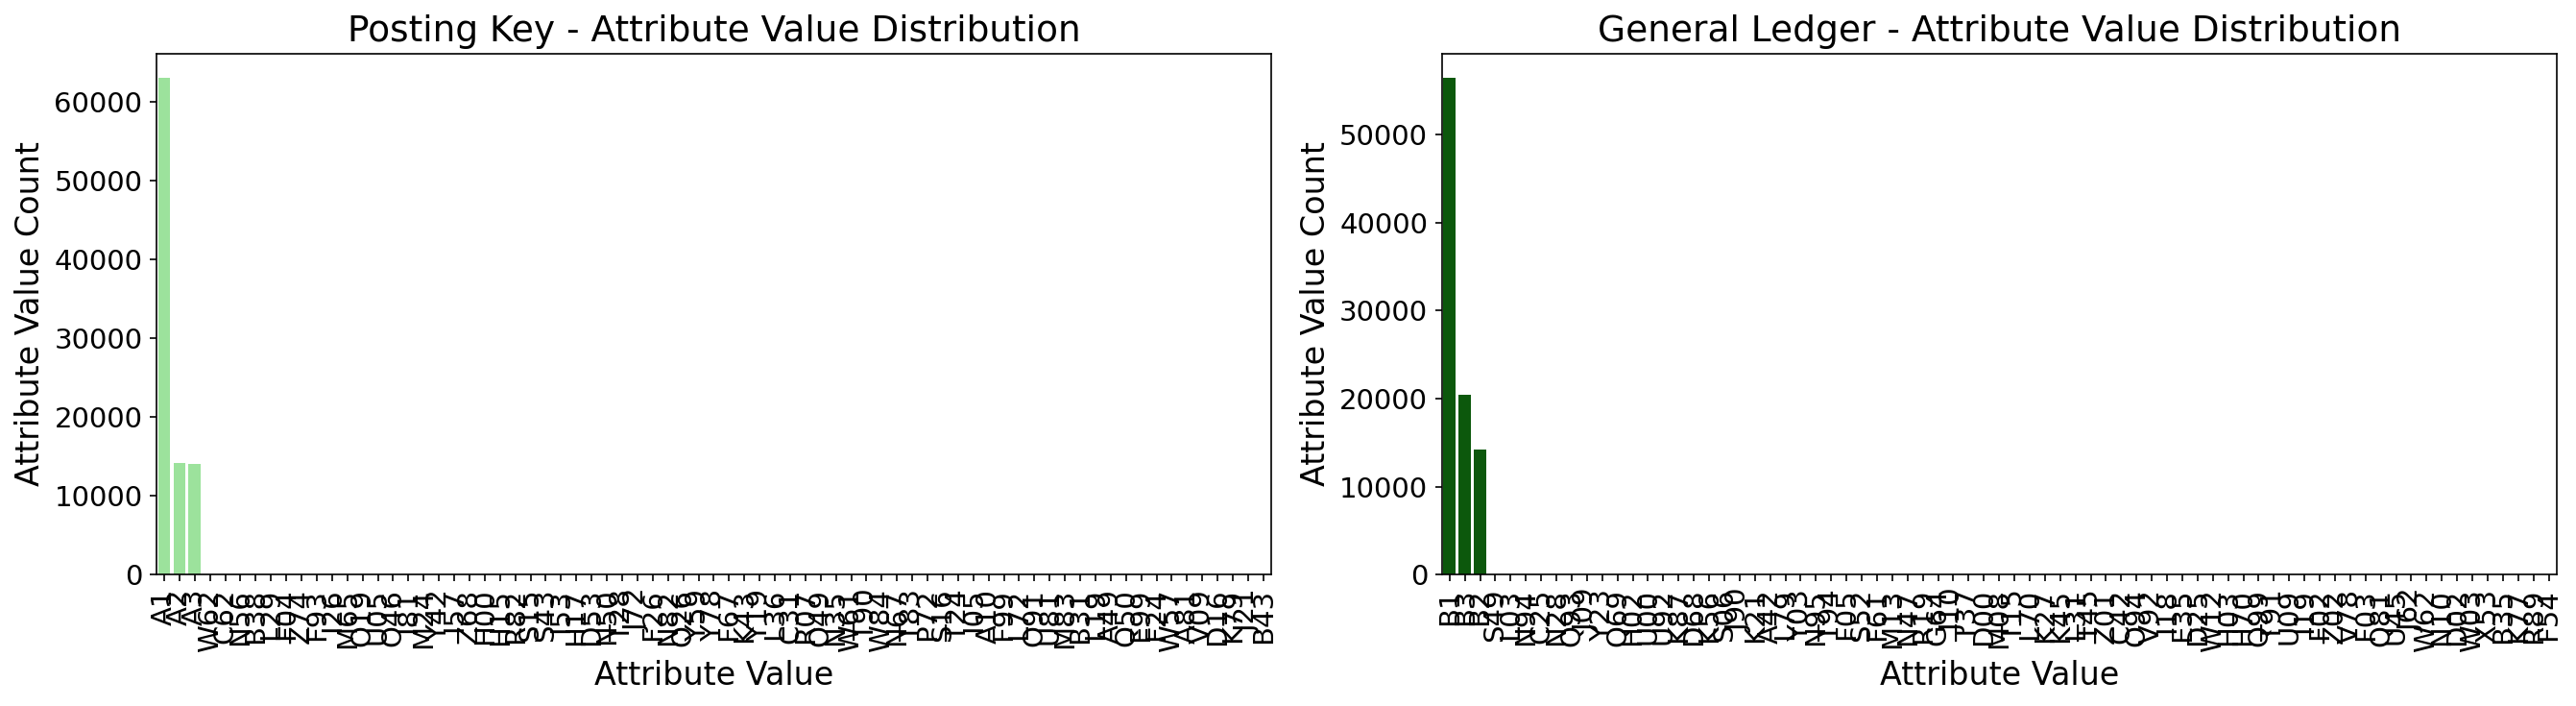

In [19]:
# Prepare to plot posting key and general ledger account side by side
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(18)

# Plot the distribution of the posting key attribute
sns.countplot(x=ori_dataset['BSCHL'], ax=ax[0], color='lightgreen')

# Set axis labels and title
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90, fontsize=12)
ax[0].set_xlabel('Attribute Value', fontsize=16)
ax[0].set_ylabel('Attribute Value Count', fontsize=16)
ax[0].set_title('Posting Key - Attribute Value Distribution', fontsize=18)
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].tick_params(axis='both', which='minor', labelsize=12)

# Plot the distribution of the general ledger attribute
sns.countplot(x=ori_dataset['HKONT'], ax=ax[1], color='darkgreen')

# Set axis labels and title
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90, fontsize=12)
ax[1].set_xlabel('Attribute Value', fontsize=16)
ax[1].set_ylabel('Attribute Value Count', fontsize=16)
ax[1].set_title('General Ledger - Attribute Value Distribution', fontsize=18)
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[1].tick_params(axis='both', which='minor', labelsize=12)

# Adjust layout
plt.tight_layout()

In general, neural networks are designed to process numerical data. One way to meet this requirement is to apply a method known as **One-Hot Encoding**. This method allows a numerical representation of categorical attribute values. With **One-Hot Encoding**, an additional binary column is created in the data for each categorical attribute value.

Consider the example in **Figure 2** below. The categorical attribute **'Receiver'** in the original data contains the names **'Sally'**, **'John'**, and **'Emma'**. We encode the attribute as a 'one-hot' attribute by creating an additional binary column for each categorical value in the "Receiver" column. For example, we encode each transaction with the value **'Sally'** in the **'Receiver'** column with the value 1.0 in the 'Sally' column. If a transaction has a different value in the **'Receiver'** column, we encode the **'Sally'** column with the value 0.0.

<img align="center" style="max-width: 500px; height: auto" src="https://github.com/HSG-AIML-Teaching/GSERM2025-Lab/blob/main/lab_06/encoding.png?raw=1">

**Figure 2:** Example of **One-Hot Encoding** of different "Receiver" attribute values into specific binary one-hot columns. Each observed attribute value in the dataset results in its own column. The column value **1.0** indicates the occurrence of the attribute value in the corresponding journal entry, while the column value **0.0** indicates that the attribute value does not occur in the corresponding journal entry.

Using this method, the six categorical attributes of the dataset can be converted into numerical attributes. The `Pandas` library offers the appropriate functionality, which we will apply as follows:

In [20]:
# select categorical attributes to be "one-hot" encoded
categorical_attr_names = ['BUKRS', 'KTOSL', 'PRCTR', 'BSCHL', 'HKONT', 'WAERS']

# encode categorical attributes into a binary one-hot encoded representation
ori_dataset_cat_processed = pd.get_dummies(ori_dataset[categorical_attr_names])

Afterward, we will verify the **One-Hot Encoding** using the first 10 journal entries of the dataset:

In [21]:
# inspect encoded sample transactions
ori_dataset_cat_processed.head(10)

,BUKRS_A43,BUKRS_A89,BUKRS_B37,BUKRS_B76,BUKRS_C10,BUKRS_C11,BUKRS_C12,BUKRS_C13,BUKRS_C14,BUKRS_C15,...,WAERS_U72,WAERS_U94,WAERS_V89,WAERS_W25,WAERS_W59,WAERS_X26,WAERS_Y59,WAERS_Z06,WAERS_Z37,WAERS_Z54
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### 3.3 Preprocessing of Numerical Attributes

Next, we will analyze the distributions of the two numerical attributes of the dataset: (1) *Amount in local currency* `DMBTR` and (2) *Amount in document currency* `WRBTR`. The values of both amount attributes exhibit a **skewed** and **steep distribution**. Therefore, we will first scale the values logarithmically. Subsequently, we will min-max normalize the scaled values:

In [22]:
# select the 'DMBTR' and 'WRBTR' attribute
numeric_attr_names = ['DMBTR', 'WRBTR']

# add a small epsilon to eliminate zero values from data for log scaling
numeric_attr = ori_dataset[numeric_attr_names] + 1e-7

# log scale the 'DMBTR' and 'WRBTR' attribute values
numeric_attr = numeric_attr.apply(np.log)

# normalize all numeric attributes to the range [0,1]
ori_dataset_num_processed = (numeric_attr - numeric_attr.min()) / (numeric_attr.max() - numeric_attr.min())

In the next step, we will visualize the distributions of the scaled and normalized values for both amount attributes:

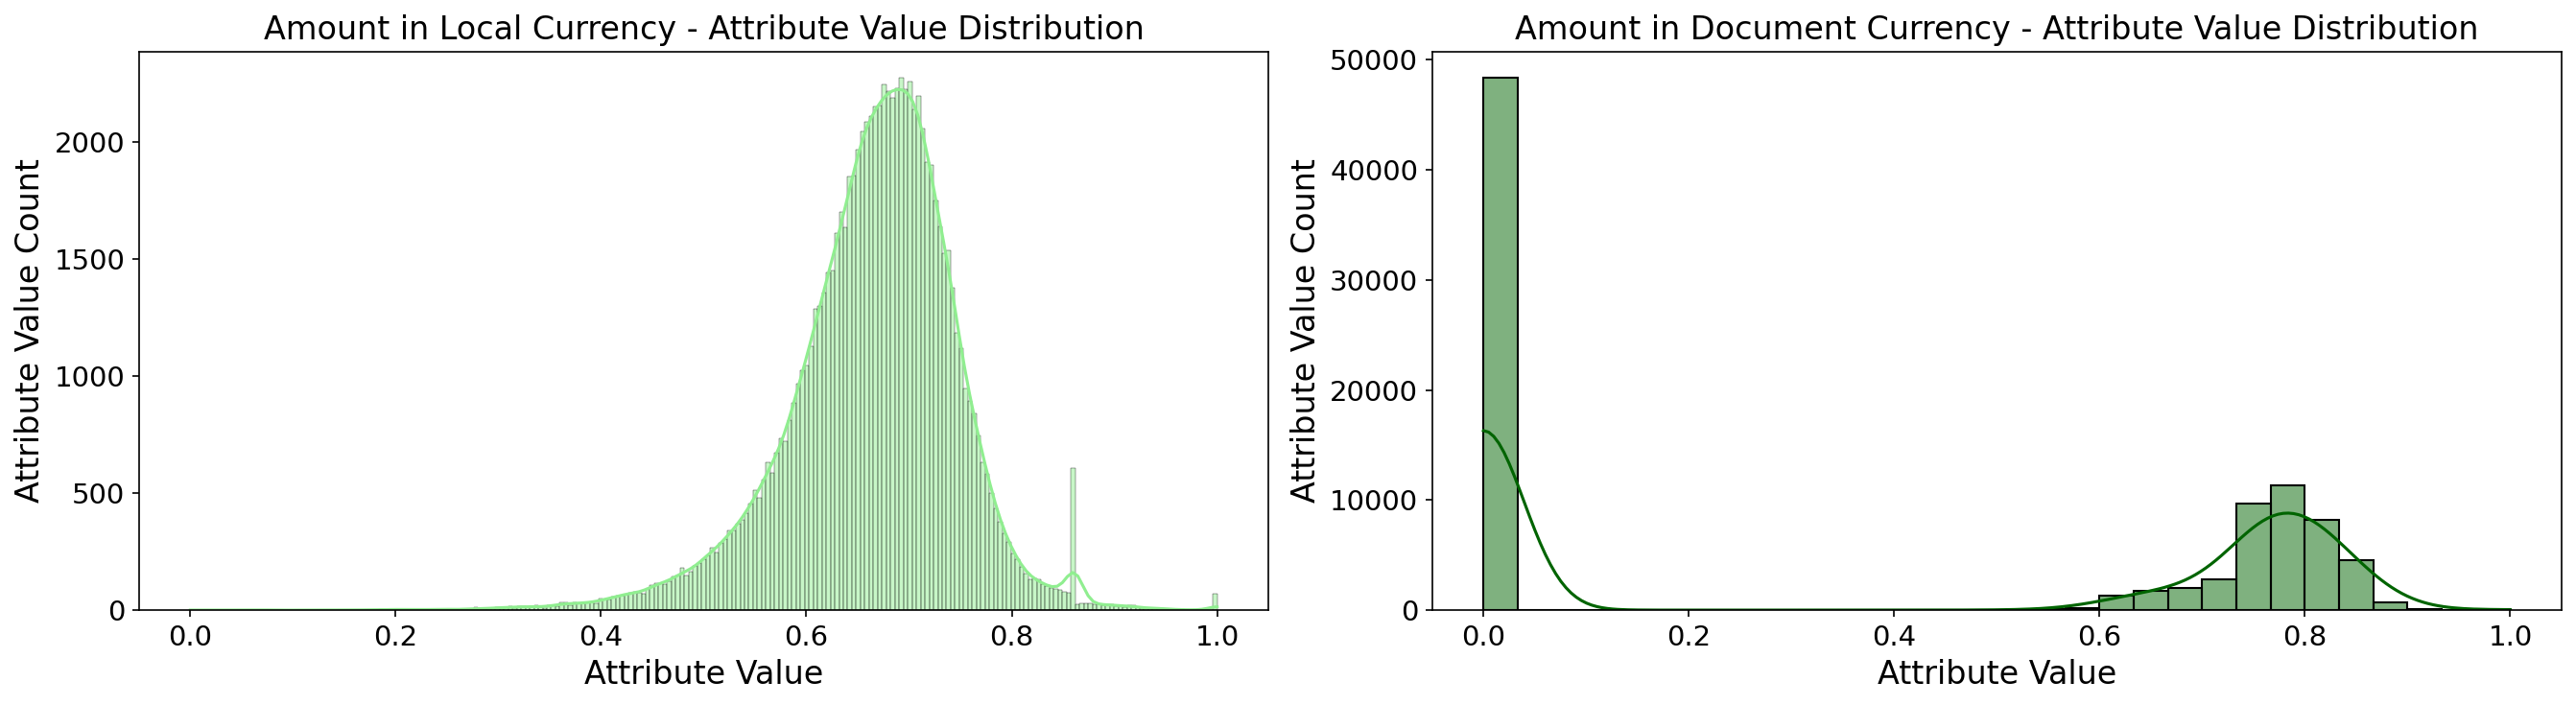

In [23]:
# init subplots
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(18)

# plot distribution of the local amount attribute
sns.histplot(ori_dataset_num_processed['DMBTR'], kde=True, ax=ax[0], color='lightgreen')

# set axis labels and title
ax[0].set_xlabel('Attribute Value', fontsize=16)
ax[0].set_ylabel('Attribute Value Count', fontsize=16)
ax[0].set_title('Amount in Local Currency - Attribute Value Distribution', fontsize=16)
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].tick_params(axis='both', which='minor', labelsize=12)

# plot distribution of the document amount attribute
sns.histplot(ori_dataset_num_processed['WRBTR'], kde=True, ax=ax[1], color='darkgreen')

# set axis labels and title
ax[1].set_xlabel('Attribute Value', fontsize=16)
ax[1].set_ylabel('Attribute Value Count', fontsize=16)
ax[1].set_title('Amount in Document Currency - Attribute Value Distribution', fontsize=16)
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[1].tick_params(axis='both', which='minor', labelsize=12)

# adjust layout
plt.tight_layout()

### 3.4 Merging Categorical and Numerical Transaction Attributes

Finally, we merge the preprocessed numerical and categorical attributes into a **single dataset**. The merged dataset will serve as the foundation for the subsequent training of the Autoencoder Neural Network (AENN):

In [24]:
# merge categorical and numeric subsets
ori_subset_transformed = pd.concat([ori_dataset_cat_processed, ori_dataset_num_processed], axis = 1)

Now, let's take a final look at the dimensionality of the merged dataset:

In [25]:
# inspect final dimensions of pre-processed transactional data
ori_subset_transformed.shape

(91247, 618)

After completing the preprocessing steps, we have a dataset consisting of a total of **91,147 records (rows)** and **618 attributes (columns)**. We should keep the number of columns in mind, as it will determine the dimensionality of the input and output layers of our AENN.

## 4. Autoencoder Neural Network Implementation

In this section, we will familiarize ourselves with the underlying concept and structure of a deep **Autoencoder Neural Network (AENN)**. We will implement the individual components and specific network architecture of AENNs using the `PyTorch` open-source library.

### 4.1 Autoencoder Neural Network Architecture

*Autoencoder Neural Networks*, also referred to as *Replicator Neural Networks*, are an unsupervised learning variant of classic feed-forward networks. This particular architecture was originally developed by Geoffrey Hinton and Ruslan Salakhutdinov. AENNs typically consist of a **symmetrical** network architecture and a central hidden layer, referred to as the **latent** or **bottleneck** layer. This layer has a lower dimensionality than the input and output layers of the network. The learning objective of the AENN is to reconstruct the original input data as accurately as possible at the output layer. **Figure 3** shows a schematic representation of an Autoencoder Neural Network:

<img align="middle" style="max-width: 800px; height: auto" src="https://github.com/HSG-AIML-Teaching/GSERM2025-Lab/blob/main/lab_06/autoencoder.png?raw=1">

**Figure 3:** Schematic representation of an **Autoencoder Neural Network**, which consists of two non-linear mappings or feed-forward networks. The two interconnected networks are referred to as the **Encoder** $f_\theta: \mathbb{R}^{dx} \mapsto \mathbb{R}^{dz}$ and **Decoder** $g_\theta: \mathbb{R}^{dz} \mapsto \mathbb{R}^{dx}$.


In general, AENNs can be interpreted as 'lossy' **compression algorithms**. They are 'lossy' in the sense that the reconstructed outputs may have errors compared to the original input data. The goal of the network is to minimize these reconstruction errors, thereby learning a compressed representation of the input data. In the context of anomaly detection, AENNs can identify patterns in the data and recognize deviations from these patterns, which may indicate anomalies.

AENNs consist of three main components:

> 1. an Encoder $f_\theta$,
> 2. a Decoder $g_\theta$,
> 3. an error function $\mathcal{L_{\theta}}$.

The encoder and decoder each consist of a classic feedforward network with learnable parameters $\theta$. The **encoder** $f_\theta(\cdot)$ maps an input vector (e.g., a journal entry) $x^i$ onto a compressed (i.e., low-dimensional) representation $z^i$ in the so-called latent space $Z$. The low-dimensional representation $z^i$ is then mapped by the **decoder** $g_\theta(\cdot)$ onto an output vector $\hat{x}^i$ in the original input space (e.g., the reconstructed journal entry). Formally, the two networks can also be represented as:



<center>$f_\theta(x^i) = s(Wx^i + b)$ &emsp; $f_\theta: \mathbb{R}^{dx} \mapsto \mathbb{R}^{dz}$,</center>
<center>$g_\theta(z^i) = s′(W′z^i + d)$ &emsp; $g_\theta: \mathbb{R}^{dz} \mapsto \mathbb{R}^{dx}$,</center>

where the two functions have the learnable model parameters $\theta = \{W, b, W', d\}$. The parameters $W \in \mathbb{R}^{d_x \times d_z}$ and $W' \in \mathbb{R}^{d_z \times d_y}$ denote the weight matrices, while $b \in \mathbb{R}^{d_x}$ and $d \in \mathbb{R}^{d_z}$ represent the bias vectors of the networks. The symbols $s$ and $s′$ denote the respective non-linear activation functions.

### 4.2 Autoencoder Neural Network Implementation

In the next step, we will implement the Encoder Network in `PyTorch`. The encoder should consist of a total of **nine layers** of fully-connected neurons, with the following number of neurons per layer: 618-256-128-64-32-16-8-4-3. This means the first layer comprises 618 neurons (determined by the dimensionality of the input data), the second layer 256 neurons, and the other layers 128, 64, 32, 16, 8, 4, and 3 neurons, respectively.

<img align="middle" style="max-width: 900px; height: auto" src="https://github.com/HSG-AIML-Teaching/GSERM2025-Lab/blob/main/lab_06/neurons.png?raw=1">

The following three elements of the encoder implementation deserve special attention:

>- `self.encoder_Lx`: defines the linear transformation of the respective layer applied to the input: $Wx + b$.
>- `nn.init.xavier_uniform`: initializes weight parameters based on a uniform Xavier distribution.
>- `self.encoder_Rx`: defines the non-linear transformation of the respective layer applied to the input: $\\sigma(\\cdot)$.

We use **Leaky ReLUs** to avoid saturating neurons and to accelerate training convergence. The application of Leaky ReLUs allows the calculation of gradients even within the negative range of an activation function (see figure above).

Next, we instantiate a model of the encoder network:

In [26]:
# implementation of the encoder network
class encoder(nn.Module):

    # define class constructor
    def __init__(self):

        # call super class constructor
        super(encoder, self).__init__()

        # specify layer 1 - in 618, out 512
        self.encoder_L1 = nn.Linear(in_features=ori_subset_transformed.shape[1], out_features=512, bias=True) # add linearity
        nn.init.xavier_uniform_(self.encoder_L1.weight) # init weights
        self.encoder_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity

        # specify layer 2 - in 512, out 256
        self.encoder_L2 = nn.Linear(512, 256, bias=True)
        nn.init.xavier_uniform_(self.encoder_L2.weight)
        self.encoder_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 3 - in 256, out 128
        self.encoder_L3 = nn.Linear(256, 128, bias=True)
        nn.init.xavier_uniform_(self.encoder_L3.weight)
        self.encoder_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 4 - in 128, out 64
        self.encoder_L4 = nn.Linear(128, 64, bias=True)
        nn.init.xavier_uniform_(self.encoder_L4.weight)
        self.encoder_R4 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 5 - in 64, out 32
        self.encoder_L5 = nn.Linear(64, 32, bias=True)
        nn.init.xavier_uniform_(self.encoder_L5.weight)
        self.encoder_R5 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 6 - in 32, out 16
        self.encoder_L6 = nn.Linear(32, 16, bias=True)
        nn.init.xavier_uniform_(self.encoder_L6.weight)
        self.encoder_R6 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 7 - in 16, out 8
        self.encoder_L7 = nn.Linear(16, 8, bias=True)
        nn.init.xavier_uniform_(self.encoder_L7.weight)
        self.encoder_R7 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 8 - in 8, out 4
        self.encoder_L8 = nn.Linear(8, 4, bias=True)
        nn.init.xavier_uniform_(self.encoder_L8.weight)
        self.encoder_R8 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 9 - in 4, out 3
        self.encoder_L9 = nn.Linear(4, 3, bias=True)
        nn.init.xavier_uniform_(self.encoder_L9.weight)
        self.encoder_R9 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

    # define forward pass
    def forward(self, x):

        # define forward pass through the network
        x = self.encoder_R1(self.encoder_L1(x))
        x = self.encoder_R2(self.encoder_L2(x))
        x = self.encoder_R3(self.encoder_L3(x))
        x = self.encoder_R4(self.encoder_L4(x))
        x = self.encoder_R5(self.encoder_L5(x))
        x = self.encoder_R6(self.encoder_L6(x))
        x = self.encoder_R7(self.encoder_L7(x))
        x = self.encoder_R8(self.encoder_L8(x))
        x = self.encoder_R9(self.encoder_L9(x))

        return x

Next, we will instantiate a model of the Encoder network:

In [27]:
# intstantiate the encoder network model
encoder_train = encoder()

Next, we will transfer the Encoder model to the `CPU` or an available `GPU`:

In [28]:
# push model to compute device
encoder_train = encoder_train.to(device)

If available, we will check whether the model has been successfully transferred to the `GPU`:

In [29]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


Now, we can visualize the model structure and review the network architecture:

In [30]:
# print the initialized architectures
now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
print('[LOG {}] encoder architecture:\n\n{}\n'.format(now, encoder_train))

[LOG 2025.06.11-12:59:42] encoder architecture:

encoder(
  (encoder_L1): Linear(in_features=618, out_features=512, bias=True)
  (encoder_R1): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L2): Linear(in_features=512, out_features=256, bias=True)
  (encoder_R2): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L3): Linear(in_features=256, out_features=128, bias=True)
  (encoder_R3): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L4): Linear(in_features=128, out_features=64, bias=True)
  (encoder_R4): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L5): Linear(in_features=64, out_features=32, bias=True)
  (encoder_R5): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L6): Linear(in_features=32, out_features=16, bias=True)
  (encoder_R6): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L7): Linear(in_features=16, out_features=8, bias=True)
  (encoder_R7): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L8): Linear(in_features=8, out_featu

Next, we will implement the Decoder Network in `PyTorch`. The decoder should consist of a total of **nine layers** of fully-connected neurons, with the following number of neurons per layer: 3-4-8-16-32-64-128-256-618. This means the first layer comprises 3 neurons (determined by the dimensionality of the latent space), the second layer 4 neurons, and the other layers 8, 16, 32, 64, 128, 256, and 618 neurons, respectively.

In [31]:
# implementation of the decoder network
class decoder(nn.Module):

    # define class constructor
    def __init__(self):

        # call super class constructor
        super(decoder, self).__init__()

        # specify layer 1 - in 3, out 4
        self.decoder_L1 = nn.Linear(in_features=3, out_features=4, bias=True) # add linearity
        nn.init.xavier_uniform_(self.decoder_L1.weight)  # init weights
        self.decoder_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity

        # specify layer 2 - in 4, out 8
        self.decoder_L2 = nn.Linear(4, 8, bias=True)
        nn.init.xavier_uniform_(self.decoder_L2.weight)
        self.decoder_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 3 - in 8, out 16
        self.decoder_L3 = nn.Linear(8, 16, bias=True)
        nn.init.xavier_uniform_(self.decoder_L3.weight)
        self.decoder_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 4 - in 16, out 32
        self.decoder_L4 = nn.Linear(16, 32, bias=True)
        nn.init.xavier_uniform_(self.decoder_L4.weight)
        self.decoder_R4 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 5 - in 32, out 64
        self.decoder_L5 = nn.Linear(32, 64, bias=True)
        nn.init.xavier_uniform_(self.decoder_L5.weight)
        self.decoder_R5 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 6 - in 64, out 128
        self.decoder_L6 = nn.Linear(64, 128, bias=True)
        nn.init.xavier_uniform_(self.decoder_L6.weight)
        self.decoder_R6 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 7 - in 128, out 256
        self.decoder_L7 = nn.Linear(128, 256, bias=True)
        nn.init.xavier_uniform_(self.decoder_L7.weight)
        self.decoder_R7 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 8 - in 256, out 512
        self.decoder_L8 = nn.Linear(256, 512, bias=True)
        nn.init.xavier_uniform_(self.decoder_L8.weight)
        self.decoder_R8 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 9 - in 512, out 618
        self.decoder_L9 = nn.Linear(in_features=512, out_features=ori_subset_transformed.shape[1], bias=True)
        nn.init.xavier_uniform_(self.decoder_L9.weight)
        self.decoder_R9 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

    # define forward pass
    def forward(self, x):

        # define forward pass through the network
        x = self.decoder_R1(self.decoder_L1(x))
        x = self.decoder_R2(self.decoder_L2(x))
        x = self.decoder_R3(self.decoder_L3(x))
        x = self.decoder_R4(self.decoder_L4(x))
        x = self.decoder_R5(self.decoder_L5(x))
        x = self.decoder_R6(self.decoder_L6(x))
        x = self.decoder_R7(self.decoder_L7(x))
        x = self.decoder_R8(self.decoder_L8(x))
        x = self.decoder_R9(self.decoder_L9(x)) # don't apply dropout to the AE output

        return x

Now, we will instantiate the Decoder model for `CPU` or `GPU` training and ensure that the model has been successfully initialized. To do this, we will visualize the network architecture by executing the following cell:

In [32]:
# intstantiate the decoder network model
decoder_train = decoder()

# print the initialized architectures
now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
print('[LOG {}] decoder architecture:\n\n{}\n'.format(now, decoder_train))

[LOG 2025.06.11-13:07:43] decoder architecture:

decoder(
  (decoder_L1): Linear(in_features=3, out_features=4, bias=True)
  (decoder_R1): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L2): Linear(in_features=4, out_features=8, bias=True)
  (decoder_R2): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L3): Linear(in_features=8, out_features=16, bias=True)
  (decoder_R3): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L4): Linear(in_features=16, out_features=32, bias=True)
  (decoder_R4): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L5): Linear(in_features=32, out_features=64, bias=True)
  (decoder_R5): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L6): Linear(in_features=64, out_features=128, bias=True)
  (decoder_R6): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L7): Linear(in_features=128, out_features=256, bias=True)
  (decoder_R7): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L8): Linear(in_features=256, out_features=51

Finally, we will transfer the Decoder model to the `CPU` or an available `GPU`:

In [33]:
# push model to compute device
decoder_train = decoder_train.to(device)

In [34]:
# init the number of encoder model parameters
encoder_num_params = 0

# iterate over the distinct encoder parameters
for param in encoder_train.parameters():

    # collect number of parameters
    encoder_num_params += param.numel()

# init the number of decoder model parameters
decoder_num_params = 0

# iterate over the distinct decoder parameters
for param in decoder_train.parameters():

    # collect number of parameters
    decoder_num_params += param.numel()

# print the number of model paramters
now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
print('[LOG {}] number of to be trained AENN model parameters: {}.'.format(now, encoder_num_params + decoder_num_params))

[LOG 2025.06.11-13:07:49] number of to be trained AENN model parameters: 985021.


Our AENN model comprises a considerable total of **985,021** parameters to be trained.

### 4.3 Autoencoder Neural Network Parameter Optimization

After successfully instantiating the AENN model, we now want to train it. Before starting the training, we need to define a suitable error function. As a reminder, our goal is to train the model so that it learns a set of encoder and decoder parameters $θ$ that maximizes the similarity between a given journal entry $x^{i}$ and its reconstruction $\hat{x}^{i} = g_θ(f_θ(x^{i}))$.

Formally, our training objective is to learn parameters $θ^*$ such that $\arg\min_{\theta} |X - g_\theta(f_\theta(X))|$. To achieve this optimization goal, we must continuously minimize the error function or **reconstruction error** $\mathcal{L_{\theta}}$ as training progresses. A suitable error function for this purpose is the **Binary Cross-Entropy (BCE)** reconstruction error, which is formally defined as follows:

<center> $\mathcal{L^{BCE}_{\theta}}(x^{i};\hat{x}^{i}) = \frac{1}{n}\sum_{i=1}^{n}\sum_{j=1}^{k} x^{i}_{j} ln(\hat{x}^{i}_{j}) + (1-x^{i}_{j}) ln(1-\hat{x}^{i}_{j})$, </center>

where $x^{i}$, $i=1,...,n$ denotes the set of journal entries, $\hat{x}^{i}$ the respective reconstructions, and $j=1,...,k$ indexes the various journal entry attributes. In the following, we will instantiate the corresponding BCE error function from the `PyTorch` library:


In [35]:
# define the optimization criterion / loss function
loss_function = nn.BCEWithLogitsLoss()

Next, we will transfer the computation of the error function to the `CPU` or an available `GPU` if applicable:

In [36]:
# push the optimization criterion / loss function to compute device
loss_function = loss_function.to(device)

Based on the error magnitude of a mini-batch of journal entries, the `PyTorch` library automatically calculates the gradients. Subsequently, the AENN parameters $θ$ are optimized based on the determined gradients. To achieve this, we only need to define the desired optimization method in `PyTorch`. In the following notebook cell, we use the **Adam Optimization** method for optimizing the model parameters $θ$. Additionally, we define a learning rate $l = 0.0001$:

In [37]:
# set the learning rate
learning_rate = 1e-4

#set the paramete optimization strategy of both networks
encoder_optimizer = torch.optim.Adam(encoder_train.parameters(), lr=learning_rate)
decoder_optimizer = torch.optim.Adam(decoder_train.parameters(), lr=learning_rate)

After successfully implementing and instantiating the three building blocks of the AENN model, let's take the time to review the definitions of the **Encoder** and **Decoder** models as well as the **BCE Reconstruction Error** and discuss any questions.

## 5. Autoencoder Neural Network Training

In this section, we aim to train an AENN model using the encoded transaction data. We will also take a detailed look at the individual training hyperparameters, training steps, and the training progress over time.

### 5.1 Training Hyperparameter Definition

Let's begin by training an AENN model for **20 training epochs** with **128 journal entries** per mini-batch. This configuration of hyperparameters means that the dataset is fed to the AENN a total of five times in mini-batches of 128 entries each. As a result, each training epoch will have **713 updates** (91,247 entries modulo 128 entries per mini-batch) of the AENN model parameters.

In [38]:
# specify training parameters
num_epochs = 20 # number of training epochs
mini_batch_size = 128 # size of the mini-batches

During the training phase, the AENN model should continuously receive mini-batches of the entire population of journal entries. For this purpose, we use the `DataLoader` functionality of the `PyTorch` library. These are iterators that continuously provide the entries in the form of mini-batches. In the following cell, we instantiate a `PyTorch DataLoader` for the journal entry data:

In [39]:
# convert pre-processed transactional data to PyTorch tensor
torch_dataset = torch.from_numpy(ori_subset_transformed.values.astype(np.float32))

# push pre-processed transactional data to compute device
torch_dataset = torch_dataset.to(device)

# init training dataloader
train_dataloader = dataloader.DataLoader(torch_dataset, batch_size=mini_batch_size, shuffle=True)

(Note: By setting the parameter `shuffle`, the distinct mini-batches contain random journal entries of the datasets provided in a different order for each epoch.)

### 5.2 Model Training

After defining the hyperparameters, we can start training the model. For each supplied mini-batch, the following steps are performed during the training process:

>1. Perform the forward pass through the encoder and decoder network.
>2. Calculate the BCE reconstruction error $\mathcal{L^{BCE}_{\theta}}(x^{i};\hat{x}^{i})$.
>3. Perform the backward pass through the encoder network.
>4. Update the encoder $f_\theta(\cdot)$ and decoder $g_\theta(\cdot)$ parameters.

To ensure learning during training, we monitor the BCE reconstruction error of the AENN model as the training progresses. Observing this makes it possible to infer the model's learning progress. Additionally, we can determine if and when the reconstruction error converges.

During the model optimization, we want to pay special attention to the following `PyTorch` instructions:

>- `reconstruction_loss.backward()`: Calculates the gradients based on the reconstruction error.
>- `encoder_optimizer.step()` and `decoder_optimizer.step()`: Update the parameters based on the gradients.

After each completed training epoch, we also want to save a **model checkpoint**. Checkpoints contain a snapshot of the model parameters. It is good practice to save such checkpoints at regular intervals during training. The training can be resumed from the last checkpoint if it is interrupted. To save a model checkpoint, we use the following `PyTorch` instruction:

>- `torch.save()`: Saves the checkpoint of the current model parameter values to the local file system.

In [40]:
# init collection of training epoch losses
train_epoch_losses = []

# set the model in training mode (apply dropout when needed)
encoder_train.train()
decoder_train.train()

# init the best loss by setting it to infinity
best_loss = np.inf

# train autoencoder model
for epoch in range(num_epochs):

    # init collection of epoch losses
    train_mini_batch_losses = []

    # init mini batch counter
    mini_batch_count = 0

    # iterate over all mini-batches
    for mini_batch_data in train_dataloader:

        # increase mini batch counter
        mini_batch_count += 1

        # push mini batch data to compute device
        mini_batch_data = mini_batch_data.to(device)

        # =================== (1) forward pass ===================================

        # run forward pass
        z_representation = encoder_train(mini_batch_data) # encode mini-batch data
        mini_batch_reconstruction = decoder_train(z_representation) # decode mini-batch data

        # =================== (2) compute reconstruction loss ====================

        # determine reconstruction loss
        reconstruction_loss = loss_function(mini_batch_reconstruction, mini_batch_data)

        # =================== (3) backward pass ==================================

        # reset graph gradients
        decoder_optimizer.zero_grad()
        encoder_optimizer.zero_grad()

        # run backward pass
        reconstruction_loss.backward()

        # =================== (4) update model parameters ========================

        # update network parameters
        decoder_optimizer.step()
        encoder_optimizer.step()

        # =================== monitor training progress ==========================

        # print training progress each 1.000 mini-batches
        if mini_batch_count % 1000 == 0:

            # print mini batch reconstuction results
            now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
            print('[LOG {}] epoch: [{}/{}], batch: {}, batch-train-loss: {}'.format(str(now), str(epoch+1), str(num_epochs), str(mini_batch_count), str(np.round(reconstruction_loss.item(), 8))))

        # collect mini-batch loss
        train_mini_batch_losses.extend([reconstruction_loss.item()])

    # =================== evaluate model performance =============================

    # determine mean min-batch loss of epoch
    train_epoch_loss = np.mean(train_mini_batch_losses)

    # print training epoch results
    now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
    print('[LOG {}] epoch: [{}/{}], epoch-train-loss: {}'.format(str(now), str(epoch+1), str(num_epochs), str(np.round(train_epoch_loss, 8))))

    # determine mean min-batch loss of epoch
    train_epoch_losses.append(train_epoch_loss)

    # =================== save model snapshot to disk ============================

    # case: new best model trained
    if train_epoch_loss < best_loss:

        # save trained encoder model file to disk
        encoder_model_name = "ep_{}_encoder_model.pth".format((epoch+1))
        torch.save(encoder_train.state_dict(), os.path.join(models_directory, encoder_model_name))

        # save trained decoder model file to disk
        decoder_model_name = "ep_{}_decoder_model.pth".format((epoch+1))
        torch.save(decoder_train.state_dict(), os.path.join(models_directory, decoder_model_name))

        # update best loss
        best_loss = train_epoch_loss

        # print epoch loss
        now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
        print('[LOG {}] epoch: [{}/{}], new best epoch-train-loss: {} found'.format(str(now), str(epoch+1), str(num_epochs), str(np.round(train_epoch_loss, 8))))

[LOG 2025.06.11-13:09:26] epoch: [1/20], epoch-train-loss: 0.09745963
[LOG 2025.06.11-13:09:26] epoch: [1/20], new best epoch-train-loss: 0.09745963 found
[LOG 2025.06.11-13:09:48] epoch: [2/20], epoch-train-loss: 0.02819295
[LOG 2025.06.11-13:09:48] epoch: [2/20], new best epoch-train-loss: 0.02819295 found
[LOG 2025.06.11-13:10:10] epoch: [3/20], epoch-train-loss: 0.02382422
[LOG 2025.06.11-13:10:11] epoch: [3/20], new best epoch-train-loss: 0.02382422 found
[LOG 2025.06.11-13:10:34] epoch: [4/20], epoch-train-loss: 0.0211641
[LOG 2025.06.11-13:10:34] epoch: [4/20], new best epoch-train-loss: 0.0211641 found
[LOG 2025.06.11-13:10:58] epoch: [5/20], epoch-train-loss: 0.01969187
[LOG 2025.06.11-13:10:58] epoch: [5/20], new best epoch-train-loss: 0.01969187 found
[LOG 2025.06.11-13:11:25] epoch: [6/20], epoch-train-loss: 0.01834428
[LOG 2025.06.11-13:11:25] epoch: [6/20], new best epoch-train-loss: 0.01834428 found
[LOG 2025.06.11-13:11:52] epoch: [7/20], epoch-train-loss: 0.01712306
[L

Next, we will visualize the reconstruction error for each training epoch:

In [ ]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figwidth(18)

# add grid
ax.grid(linestyle='dotted')

# plot the training epochs vs. the epochs' prediction error
ax.plot(np.array(range(1, len(train_epoch_losses)+1)), train_epoch_losses, label='epoch loss (blue)')

# add axis legends
ax.set_xlabel("[Training Epoch $e_i$]", fontsize=14)
ax.set_ylabel("[Reconstruction Error $\mathcal{L}^{BCE}$]", fontsize=14)

# set plot legend
plt.legend(loc="upper right", numpoints=1, fancybox=True)

# add plot title
plt.title('Training Epochs $e_i$ vs. Reconstruction Error $L^{BCE}$', fontsize=16);

It can be observed that the reconstruction error of the AENN model begins to decrease continuously after five epochs. This implies that the model is gradually succeeding in reconstructing the journal entries contained within the dataset. However, the visualization also shows that the model could be trained for several more epochs until the reconstruction error no longer decreases or converges.

## 6. Autoencoder Neural Network Model Evaluation

In this section, we will evaluate the learned AENN model's ability to detect anomalies in journal entry data. We will use pre-trained AENN models for this purpose. The evaluation includes both **local** and **global** anomalies in the dataset.

### 6.1 Loading a Model Checkpoint

We typically load the AENN model with the **lowest** reconstruction error or use another pre-trained model for the evaluation. During training, we saved a checkpoint of the model parameters for each epoch in the local model directory. We will now load a model checkpoint that has already been trained for **30 training epochs**:

In [ ]:
# restore pre-trained model checkpoint
encoder_model_name = 'https://raw.githubusercontent.com/HSG-AIML-Teaching/GSERM2025-Lab/main/lab_06/models_ano/ep_30_encoder_model_small.pth'
decoder_model_name = 'https://raw.githubusercontent.com/HSG-AIML-Teaching/GSERM2025-Lab/main/lab_06/models_ano/ep_30_decoder_model_small.pth'

# read stored model from the remote location
encoder_bytes = urllib.request.urlopen(encoder_model_name)
decoder_bytes = urllib.request.urlopen(decoder_model_name)

# load tensor from io.BytesIO object
encoder_buffer = io.BytesIO(encoder_bytes.read())
decoder_buffer = io.BytesIO(decoder_bytes.read())

# init evaluation encoder and decoder model
encoder_eval = encoder()
decoder_eval = decoder()

# push encoder and decoder model to compute device
encoder_eval = encoder_train.to(device)
decoder_eval = decoder_train.to(device)

# load trained models
encoder_eval.load_state_dict(torch.load(encoder_buffer, map_location=lambda storage, loc: storage))
decoder_eval.load_state_dict(torch.load(decoder_buffer, map_location=lambda storage, loc: storage))

### 6.2 Model Evaluation

After successfully loading the model checkpoint, we transfer the model for evaluation purposes to the `CPU` (Note: This allows us to calculate the reconstruction errors of all journal entries without any limitations due to the `GPU` memory):

In [ ]:
# set networks in evaluation mode (don't apply dropout)
encoder_eval.eval()
decoder_eval.eval()

# push encoder and decoder model to compute device
encoder_eval = encoder_eval.to('cpu')
decoder_eval = decoder_eval.to('cpu')

# push the dataset to the CPU
torch_dataset = torch_dataset.to('cpu')

# push the loss function to the CPU
loss_function = loss_function.to('cpu')

Next, we will calculate the dataset's **individual** BCE reconstruction errors for each journal entry $x_{i}$. First, the reconstruction $\hat{x}_{i}$ of each entry is determined. Second, the BCE reconstruction error of the reconstructed entry $\hat{x}{i}$ is calculated by comparing it to the original journal entries $x_{i}$ from the dataset:

In [ ]:
# reconstruct encoded transactional data
reconstruction = decoder_eval(encoder_eval(torch_dataset))

# init binary cross entropy errors
reconstruction_loss_transaction = np.zeros(reconstruction.size()[0])

# iterate over all detailed reconstructions
for i in range(0, reconstruction.size()[0]):

    # determine reconstruction loss - individual transactions
    reconstruction_loss_transaction[i] = loss_function(reconstruction[i], torch_dataset[i]).item()

    if(i % 10000 == 0):

        ### print conversion summary
        now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
        print('[LOG {}] collected individual reconstruction loss of: {:06}/{:06} transactions'.format(now, i, reconstruction.size()[0]))

After calculating the individual reconstruction errors, we will visualize the magnitude of each error:

In [ ]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# set plot size
fig.set_figwidth(16)
fig.set_figheight(8)

# assign unique id to transactions
plot_data = np.column_stack((np.arange(len(reconstruction_loss_transaction)), reconstruction_loss_transaction))

# obtain regular transactions as well as global and local anomalies
regular_data = plot_data[label == 'regular']
global_outliers = plot_data[label == 'global']
local_outliers = plot_data[label == 'local']

# plot reconstruction error scatter plot
ax.scatter(regular_data[:, 0], regular_data[:, 1], c='C0', alpha=0.4, marker="o", s=30, label='regular') # plot regular transactions
ax.scatter(global_outliers[:, 0], global_outliers[:, 1], c='C1', marker="^", s=80, label='global') # plot global outliers
ax.scatter(local_outliers[:, 0], local_outliers[:, 1], c='C2', marker="*", s=80, label='local') # plot local outliers

# add plot legend of transaction classes
ax.legend(loc='best')

# add axis legends
ax.set_xlabel("[Journal Entry ID $x_i$]", fontsize=14)
ax.set_ylabel("[Reconstruction Error $\mathcal{L}^{BCE}$]", fontsize=14)

# add plot title
plt.title('Journal Entry ID $x_i$ vs. Reconstruction Error $L^{BCE}$', fontsize=16);

The visualization shows that our AENN model can reconstruct most regular journal entries with low error. Simultaneously, both the **global anomalies** (green) and **local anomalies** (red) exhibit a comparatively high reconstruction error. Based on this analysis, we can conclude that it is possible to differentiate **anomalies** (green and red) from regular journal entries (blue) within the dataset using reconstruction errors.

To further investigate this observation, we will now filter out journal entries that have a **reconstruction error >= 0.12** from the dataset. We assume (as demonstrated above) that these journal entries correspond to the **global anomalies** within the total population of journal entries.

In [ ]:
# append labels to original dataset
ori_dataset['label'] = label

# extract transactions exhibiting a reconstruction error >= 0.12
autoencoder_global_anomalies = ori_dataset[reconstruction_loss_transaction >= 0.12]

# inspect transactions exhibiting a reconstruction error >= 0.12
autoencoder_global_anomalies

Let's now extract the journal entries into an Excel table to make them available to the audit team. First, we will generate a timestamp of the data extract for the audit trail:

In [ ]:
timestamp = dt.datetime.utcnow().strftime("%Y-%m-%d_%H-%M-%S")

Next, we will extract the filtered **global anomalies** as an Excel file for further substantive testing:

In [ ]:
# specify the filename of the excel spreadsheet
filename = str(timestamp) + " - ACA_001_autoencoder_global_anomalies.xlsx"

# specify the target data directory of the excel spreadsheet
data_directory = os.path.join(results_directory, filename)

# extract the filtered transactions to excel
autoencoder_global_anomalies.to_excel(data_directory, header=True, index=False, sheet_name="Global_Anomalies")

Now, let's closely examine the journal entries with a **reconstruction error >= 0.04 but <= 0.12**. We assume (as illustrated above) that these journal entries correspond to the **local anomalies** within the population of journal entries:

In [ ]:
# extract transactions exhibiting a reconstruction error < 0.12 and >= 0.04
autoencoder_local_anomalies = ori_dataset[(reconstruction_loss_transaction >= 0.04) & (reconstruction_loss_transaction < 0.12)]

# inspect transactions exhibiting a reconstruction error < 0.12 and >= 0.04
autoencoder_local_anomalies

Next, we will again extract the filtered journal entries into an Excel table to make them available to the audit team. First, we will generate a timestamp of the data extract for the audit trail:

In [ ]:
timestamp = dt.datetime.utcnow().strftime("%Y-%m-%d_%H-%M-%S")

Following that, we will extract the filtered **local anomalies** as an Excel file for further substantive testing:

In [ ]:
# specify the filename of the excel spreadsheet
filename = str(timestamp) + " - ACA_002_autoencoder_local_anomalies.xlsx"

# specify the target data directory of the excel spreadsheet
data_directory = os.path.join(results_directory, filename)

# extract the filtered transactions to excel
autoencoder_local_anomalies.to_excel(data_directory, header=True, index=False, sheet_name="Local_Anomalies")

## 7. Evaluation of Journal Entry Representations

In a real-world audit context, it's generally beneficial to examine the **learned representations** of the journal entries by the AENN model in addition to the reconstruction error. This examination provides insights into the **structural semantics** of the entries and their corresponding attributes. Additionally, this analysis allows us to contextualize any identified anomalies within the population of journal entries.

To obtain the representation of the journal entry, we perform a forward pass through the encoder of the AENN model for each journal entry. For this, we load an encoder network **model checkpoint** trained for 80 epochs:

In [ ]:
# restore pretrained model checkpoint
encoder_model_name = 'https://raw.githubusercontent.com/HSG-AIML-Teaching/GSERM2025-Lab/main/lab_06/models_ano/ep_80_encoder_model_small.pth'

# read stored model from the remote location
encoder_bytes = urllib.request.urlopen(encoder_model_name)

# load tensor from io.BytesIO object
encoder_buffer = io.BytesIO(encoder_bytes.read())

# init evaluation encoder and decoder model
encoder_eval = encoder()

# push encoder and decoder model to compute device
encoder_eval = encoder_eval.to('cpu')

# load trained models
encoder_eval.load_state_dict(torch.load(encoder_buffer, map_location=lambda storage, loc: storage))

Next, we will perform a forward pass through the AENN model for each journal entry. Consequently, we will obtain the three-dimensional representation of each entry:

In [ ]:
# push the dataset to the CPU
torch_dataset = torch_dataset.to('cpu')

# run forward path through encoder to obtain journal entry representations
entry_representations = encoder_eval(torch_dataset)

# convert the representations to a pandas dataframe
entry_representation = pd.DataFrame(entry_representations.data.cpu().numpy(), columns=['z1', 'z2', 'z3'])

Subsequently, for validation and visualization purposes, we will label the representations with the original labels:

In [ ]:
entry_representation['label'] = label

Before visualizing, let's carefully examine the obtained coordinates:

In [ ]:
entry_representation.head(10)

Due to the three-dimensional **latent space**, we can visualize the space and the representations using the `Matplotlib 3D` functionality. In the following cell, we will create a visualization of this space and the representations:

In [ ]:
# enforce inline plotting
%matplotlib inline

# import 3d plotting and animation libraries
from IPython.display import HTML
from matplotlib import animation
from mpl_toolkits.mplot3d import axes3d

# init the plot
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')

# change plot perspective
ax.view_init(elev=30, azim=240)

# set axis paramaters of subplot
ax.grid(linestyle='dotted')

# plot regular transactions, just the first 1000 to gain an intuition
regular = entry_representation[entry_representation['label'] == 'regular']
ax.scatter(regular['z1'][0:2000], regular['z2'][0:2000], regular['z3'][0:2000], c='C0', alpha=0.4, marker="o", label='regular')

# plot first order anomalous transactions
global_anomalies = entry_representation[entry_representation['label'] == 'global']
ax.scatter(global_anomalies['z1'], global_anomalies['z2'], global_anomalies['z3'], c='C1', s=100, marker="^", label='global')

# plot second order anomalous transactions
local_anomalies = entry_representation[entry_representation['label'] == 'local']
ax.scatter(local_anomalies['z1'], local_anomalies['z2'], local_anomalies['z3'], c='C2', s=100, marker="*", label='local')

# set axis labels
ax.set_xlabel('activation [$z_1$]', weight='normal', fontsize=12)
ax.set_ylabel('activation [$z_2$]', weight='normal', fontsize=12)
ax.set_zlabel('activation [$z_3$]', weight='normal', fontsize=12)

# add plot legend of transaction classes
ax.legend(loc='best')

# set plot title
plt.title('AEEN Model Latent Space', fontsize=10);

## 8. Lab Summary

In this lab, you successfully accomplished the following key learnings:

> 1. **Understanding Autoencoder Neural Network Design:** Mastered the fundamental concepts and architectural design of autoencoder neural networks (AENNs), enhancing your comprehension of deep learning models tailored for anomaly detection in accounting data.
> 2. **Model Implementation and Training:** Developed practical skills in implementing and training an AENN model using PyTorch, applying it to synthetic financial datasets to detect anomalies in journal entries.
> 3. **Evaluating Model Performance:** Gained expertise in evaluating the performance of AENN models through metrics such as reconstruction error and effectively utilized these metrics to identify local and global anomalies.
> 4. **Visualization and Interpretation of Representations:** Learned to visualize and interpret the learned representations of journal entries, providing deeper insights into the structural semantics of the data and facilitating the contextualization of anomalies.

This lab provided insights into designing, implementing, training, and evaluating AENNs for unsupervised anomaly detection. It equipped you with tools and techniques for effective model building, evaluation, and application. These skills are invaluable for succeeding in deep learning.